### Short description
This notebook is a part of [Data Sprint #35: Osteoarthritis Knee X-ray](https://dphi.tech/challenges/data-sprint-35-osteoarthritis-knee-x-ray/81/leaderboard/datathon/) challenge hosted on [dphi.tech](https://dphi.tech/)

## Importing dependencies

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model

# Basic Idea
The Basic idea is to use external data present in kaggle here: [Kaggle: Knee Osteoarthritis Dataset with KL Grading - 2018](https://www.kaggle.com/tommyngx/kneeoa)

As we have labels for train, validation and test, we will combine all splits into one and test it on dataset provided by the compitition team, this will make sure kaggle dataset and compitition dataset has same data distribution.

If train(kaggle dataset) and test (compition dataset) data has same distribution then their metric score should be roughy be the same (accuracy score in our case).

# Read And Combining train dataset (kaggle dataset)

In [2]:
# number of class
n_class = 5

# path to kaggle dataset
root_path = "/kaggle/input/kneeoa/"

# list of folders
folder_list = os.listdir(root_path)
image_path_list = []
label_list = []

# for each folder, get the image path and labels
for folder in folder_list:
    for label in range(n_class):
        
        # get all the images path inside the current folder
        image_list = os.listdir(f"{root_path}{folder}/{label}")
        # add to the image path list
        image_path_list += [ f"{root_path}{folder}/{label}/"+ path for path in image_list]
        
        # add labels to the label list
        label_list += [label] * len(image_list)

# convert to dataframe
df_train_kaggle = pd.DataFrame({"filepath" : image_path_list, "label": label_list})

In [3]:
df_train_kaggle.shape

(9786, 2)

### Observation
we have total of 9786 images in kaggle dataset. We will use data to train the deep learning model
# Lets look at class distribution

Text(0, 0.5, 'count')

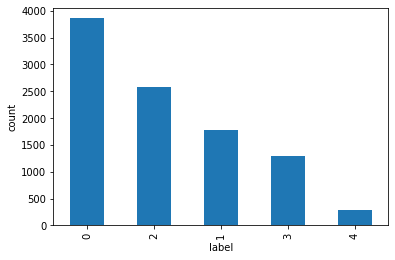

In [4]:
df_train_kaggle.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

### Observation
As our dataset is imbalanced, we will balance our class by weighting majority class less and minoiry class more

## DataGenerator train and validation
We will use kaggle dataset as train set and compitition dataset as validation set. If train and validation metric is similar, it shows their distribution is similar and hence we can use kaggle dataset as well.

In [5]:
# train data generator object
train_aug = ImageDataGenerator(rescale=1./255)

# validation data generator object
valid_aug = ImageDataGenerator(rescale=1./255)

In [6]:
# create train generator
train_generator = train_aug.flow_from_dataframe(
dataframe=df_train_kaggle,
directory=None,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 9786 validated image filenames.


# Create validation dataframe using compitition dataset.
We will download compition dataset from gdrive and use it as validation set to validated against kaggle dataset

In [7]:
# download data from shared google drive link
!pip install gdown
!gdown --id "1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC"

  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - done
  Created wheel for gdown: filename=gdown-3.13.0-py3-none-any.whl size=9034 sha256=c793beb0da2ea92b5e7a778b64d9e2e5abeb79380d94bd77a13e42f48534139f
  Stored in directory: /root/.cache/pip/wheels/2f/2a/2f/86449b6bdbaa9aef873f68332b68be6bfbc386b9219f47157d
Successfully built gdown
Downloading...
From: https://drive.google.com/uc?id=1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC
To: /kaggle/working/KneeXray.zip
120MB [00:00, 128MB/s]


In [8]:
# unzip the data
!unzip -q -o /kaggle/working/KneeXray.zip -d /kaggle/working/

In [9]:
# read Train.csv file which contains image names and labels and preprocess them
compi_root_path= "/kaggle/working/KneeXray/"
df_val_compi = pd.read_csv(compi_root_path + "Train.csv")

# add absolute path to the image names
df_val_compi["filename"] = df_val_compi.filename.apply(lambda x: compi_root_path+"train/" + x)
df_val_compi.head()

,filename,label
0,/kaggle/working/KneeXray/train/Image_1.jpg,0
1,/kaggle/working/KneeXray/train/Image_2.jpg,1
2,/kaggle/working/KneeXray/train/Image_3.jpg,0
3,/kaggle/working/KneeXray/train/Image_4.jpg,1
4,/kaggle/working/KneeXray/train/Image_5.jpg,2


Text(0, 0.5, 'count')

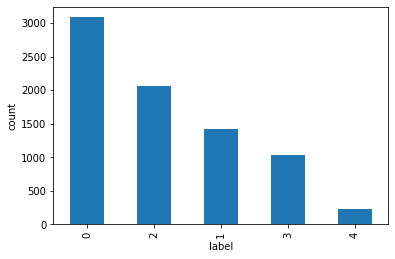

In [10]:
# class count of compitition dataset
df_val_compi.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [11]:
# create validation generator
valid_generator = valid_aug.flow_from_dataframe( 
dataframe= df_val_compi,
x_col= "filename",
y_col= "label",
batch_size= 32,
seed= 42,
shuffle= True,
class_mode= "raw",
target_size= (224,224))

Found 7828 validated image filenames.


### Model Architecture
Here we will be using Xception by google. (I encourage you to try different architectures)

In [12]:
xception = Xception(weights="imagenet",)
x=  xception.layers[-3].output

x = tf.keras.layers.Conv2D(filters= 1024, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 256, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= 64, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

x = tf.keras.layers.Conv2D(filters= n_class, kernel_size= 3, padding= "same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)

GAP = tf.keras.layers.GlobalAveragePooling2D()(x)
pred = tf.keras.activations.softmax(GAP)

xception_model = Model(inputs=xception.input,outputs=pred)

91889664/91884032 [==============================] - 1s 0us/step


In [13]:
# compile
xception_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "xception_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=5,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=5,
                                verbose=1)
]

### Weighting classes
As we have unevenly class distibution, we will weight them based on the number of samples

In [14]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(df_train_kaggle.label.values),
                                                 y= df_train_kaggle.label.values)
class_weights = dict(enumerate(class_weights))

# Train
Lets roll

In [15]:
# train the model
xception_model.fit(
        train_generator,
        epochs=100,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
xception_model.load_weights(checkpoint_path)

Epoch 1/100
306/306 [==============================] - 160s 492ms/step - loss: 1.4874 - acc: 0.2672 - val_loss: 1.5530 - val_acc: 0.3222

Epoch 00001: val_acc improved from -inf to 0.32218, saving model to xception_best.ckpt
Epoch 2/100
306/306 [==============================] - 148s 485ms/step - loss: 1.1988 - acc: 0.4614 - val_loss: 1.5651 - val_acc: 0.3591

Epoch 00002: val_acc improved from 0.32218 to 0.35910, saving model to xception_best.ckpt
Epoch 3/100
306/306 [==============================] - 148s 484ms/step - loss: 1.0371 - acc: 0.5566 - val_loss: 1.2076 - val_acc: 0.5902

Epoch 00003: val_acc improved from 0.35910 to 0.59019, saving model to xception_best.ckpt
Epoch 4/100
306/306 [==============================] - 149s 486ms/step - loss: 0.9348 - acc: 0.6363 - val_loss: 1.1493 - val_acc: 0.6316

Epoch 00004: val_acc improved from 0.59019 to 0.63158, saving model to xception_best.ckpt
Epoch 5/100
306/306 [==============================] - 148s 485ms/step - loss: 0.8530 - acc

### Observation
As we can see train and validation accuracy is pretty close, which proves kaggle and competition data has come from the same distribution and we can freely use it to experiment with.

## Retraining last trained model on competition data
As we have used competition data as validation set previously, we will use it as train set now (and some part of it as validation set) hoping this additional training would give our model new information to perform better.

In [16]:
# train and validation split on competition data
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_val_compi,
                                   test_size=0.1,
                                   random_state=42,
                                   stratify= df_val_compi.label)

In [17]:
train_generator = train_aug.flow_from_dataframe(
dataframe = X_train,
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 7045 validated image filenames.


In [18]:
valid_generator = valid_aug.flow_from_dataframe( 
dataframe=X_test,
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 783 validated image filenames.


In [19]:
# number of steps to consider 1 as  epoch
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID =valid_generator.n//valid_generator.batch_size

In [20]:
# kick off training
xception_model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=50,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,callbacks=[my_callbacks])

Epoch 1/50
220/220 [==============================] - 97s 429ms/step - loss: 0.6779 - acc: 0.9090 - val_loss: 0.6368 - val_acc: 0.9076

Epoch 00001: val_acc did not improve from 0.92872
Epoch 2/50
220/220 [==============================] - 94s 427ms/step - loss: 0.6138 - acc: 0.9507 - val_loss: 0.6104 - val_acc: 0.9349

Epoch 00002: val_acc improved from 0.92872 to 0.93490, saving model to xception_best.ckpt
Epoch 3/50
220/220 [==============================] - 94s 426ms/step - loss: 0.5709 - acc: 0.9788 - val_loss: 0.5849 - val_acc: 0.9714

Epoch 00003: val_acc improved from 0.93490 to 0.97135, saving model to xception_best.ckpt
Epoch 4/50
220/220 [==============================] - 94s 426ms/step - loss: 0.5659 - acc: 0.9815 - val_loss: 0.5907 - val_acc: 0.9570

Epoch 00004: val_acc did not improve from 0.97135
Epoch 5/50
220/220 [==============================] - 94s 427ms/step - loss: 0.5560 - acc: 0.9859 - val_loss: 0.5901 - val_acc: 0.9583

Epoch 00005: val_acc did not improve fro

In [21]:
# load best saved weights
xception_model.load_weights(checkpoint_path)

# Confusion Matrix
As our data set is imbalaned, lets see where is our model making mistakes. I encourage to you to take initative for bringing FPs and FNs down.

In [22]:
from sklearn.metrics import precision_recall_curve
target_shape = 224
BATCH_SIZE = 1

# test generator
compi_gen = valid_aug.flow_from_dataframe(dataframe= X_test,
                            x_col= "filename",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )

Found 783 validated image filenames.


In [23]:
# prediction on train data
predicition_compi = xception_model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

783/783 [==============================] - 10s 11ms/step


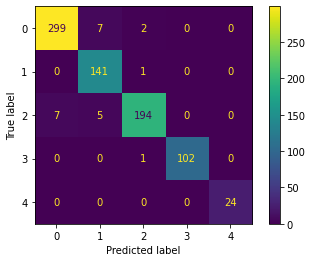

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

## Making prediction on test set (to make submission)
Finally we save the predictions on disk in CSV format

In [25]:
# read the csv file
test = pd.read_csv(compi_root_path + "Test.csv")

# create test generator
test_generator = valid_aug.flow_from_dataframe(
dataframe= test,
directory= compi_root_path + "test",
x_col= "filename",
y_col= None,
batch_size= 1,
seed= 42,
shuffle= False,
class_mode= None,
target_size= (224,224))

# number of steps to consider 1 epoch
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 1958 validated image filenames.


In [26]:
# make prediction and create dataframe out of it
pred = xception_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)
df_submit = pd.DataFrame({"label":np.argmax(pred, axis= 1)})
df_submit["label"].value_counts()

1958/1958 [==============================] - 21s 11ms/step


0    770
2    508
1    359
3    262
4     59
Name: label, dtype: int64

### Clearing the working directory
Because if don't, "output" tabl will show only images

In [27]:
import sys
import shutil

# Get directory name
mydir = "/kaggle/working"

try:
    shutil.rmtree(mydir)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

Error: /kaggle/working - Device or resource busy.


### Save best weights and output prediction file

In [28]:
xception_model.save_weights("knee_xray_Xceptionnet_GPA.h5")
df_submit.to_csv("submission.csv",index=False)

The submission results in 96.8% on public leaderboard.

**Suggestion to improve the score**
* Using right data augmentations
* Using different model architecture
* Ensembling and stacking
* Using pretrained model trained on xray images